## Use SVM and SGD to attempt to model and predict the class of an internet connection request.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# from google.colab import drive

In [ ]:
# drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# dataset_file = '/content/drive/MyDrive/' + 'log2.csv'

In [2]:
dt=pd.read_csv('log2.csv')

In [3]:
dt.head()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,allow,177,94,83,2,30,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18


In [4]:
#Data types
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65532 entries, 0 to 65531
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Source Port           65532 non-null  int64 
 1   Destination Port      65532 non-null  int64 
 2   NAT Source Port       65532 non-null  int64 
 3   NAT Destination Port  65532 non-null  int64 
 4   Action                65532 non-null  object
 5   Bytes                 65532 non-null  int64 
 6   Bytes Sent            65532 non-null  int64 
 7   Bytes Received        65532 non-null  int64 
 8   Packets               65532 non-null  int64 
 9   Elapsed Time (sec)    65532 non-null  int64 
 10  pkts_sent             65532 non-null  int64 
 11  pkts_received         65532 non-null  int64 
dtypes: int64(11), object(1)
memory usage: 6.0+ MB


In [5]:
#Lets look at the data
dt.describe()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
count,65532.000000,65532.000000,65532.000000,65532.000000,6.553200e+04,6.553200e+04,6.553200e+04,6.553200e+04,65532.000000,65532.000000,65532.000000
mean,49391.969343,10577.385812,19282.972761,2671.049930,9.712395e+04,2.238580e+04,7.473815e+04,1.028660e+02,65.833577,41.399530,61.466505
std,15255.712537,18466.027039,21970.689669,9739.162278,5.618439e+06,3.828139e+06,2.463208e+06,5.133002e+03,302.461762,3218.871288,2223.332271
min,0.000000,0.000000,0.000000,0.000000,6.000000e+01,6.000000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
25%,49183.000000,80.000000,0.000000,0.000000,6.600000e+01,6.600000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
50%,53776.500000,445.000000,8820.500000,53.000000,1.680000e+02,9.000000e+01,7.900000e+01,2.000000e+00,15.000000,1.000000,1.000000
75%,58638.000000,15000.000000,38366.250000,443.000000,7.522500e+02,2.100000e+02,4.490000e+02,6.000000e+00,30.000000,3.000000,2.000000
max,65534.000000,65535.000000,65535.000000,65535.000000,1.269359e+09,9.484772e+08,3.208818e+08,1.036116e+06,10824.000000,747520.000000,327208.000000


In [6]:
#Missing Attributes
#No missing values
dt.isna().sum()

Source Port             0
Destination Port        0
NAT Source Port         0
NAT Destination Port    0
Action                  0
Bytes                   0
Bytes Sent              0
Bytes Received          0
Packets                 0
Elapsed Time (sec)      0
pkts_sent               0
pkts_received           0
dtype: int64

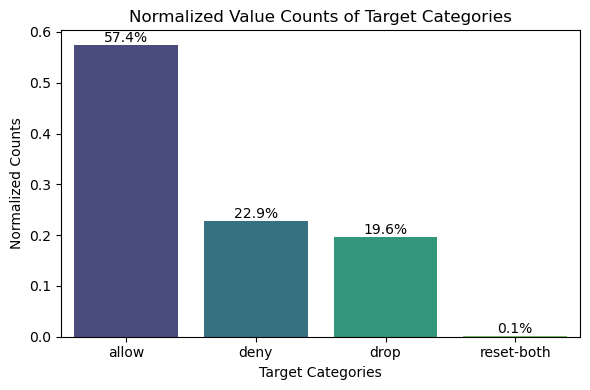

In [7]:
# Look at the targets distribution
target_dt=dt["Action"].value_counts(normalize=True)

import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
ax = sns.barplot(x=target_dt.index, y=target_dt.values, palette="viridis")
plt.xlabel("Target Categories")
plt.ylabel("Normalized Counts")
plt.title("Normalized Value Counts of Target Categories")

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1%}', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom')


plt.tight_layout()
plt.show()

In [ ]:
dt[dt["Elapsed Time (sec)"]==0]

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
141,51048,445,0,0,drop,70,70,0,1,0,1,0
142,51045,445,0,0,drop,70,70,0,1,0,1,0
143,13394,23,0,0,deny,60,60,0,1,0,1,0
144,61078,57470,0,0,deny,62,62,0,1,0,1,0
145,55725,445,0,0,drop,70,70,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
65523,55142,26467,0,0,deny,66,66,0,1,0,1,0
65524,53848,36237,0,0,deny,62,62,0,1,0,1,0
65529,54871,445,0,0,drop,70,70,0,1,0,1,0
65530,54870,445,0,0,drop,70,70,0,1,0,1,0


+ If there are no Bytes received then time elapsed is 0 as well as pkts received and NAT ports
+ The Zeros in the data do make sense

In [ ]:
print("Unique Ports")
print(f'Source Port: {len(dt["Source Port"].unique())} ')
print(f'Destination Port: {len(dt["Destination Port"].unique())} ')
print(f'NAT Source Port: {len(dt["NAT Source Port"].unique())} ')
print(f'NAT Destination Port: {len(dt["NAT Destination Port"].unique())} ')


Unique Ports
Source Port: 22724 
Destination Port: 3273 
NAT Source Port: 29152 
NAT Destination Port: 2533 


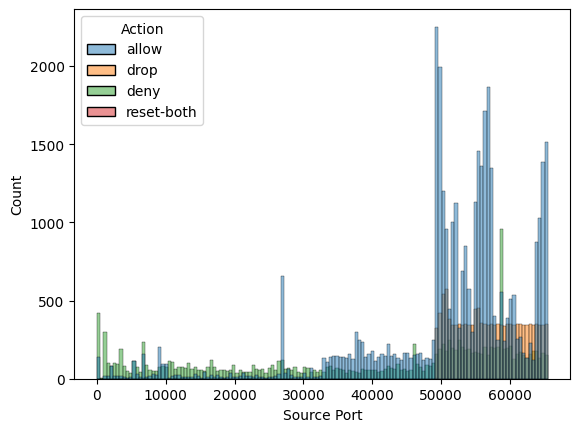

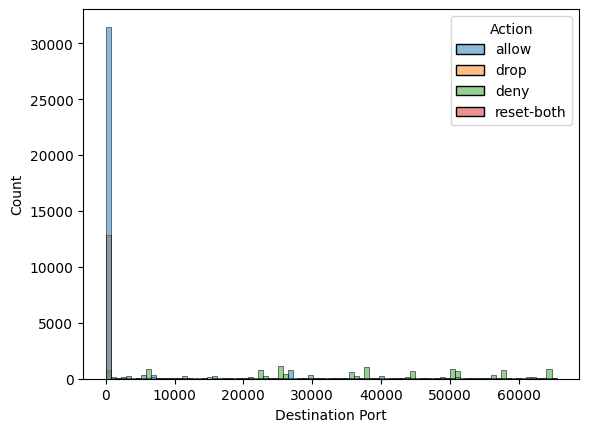

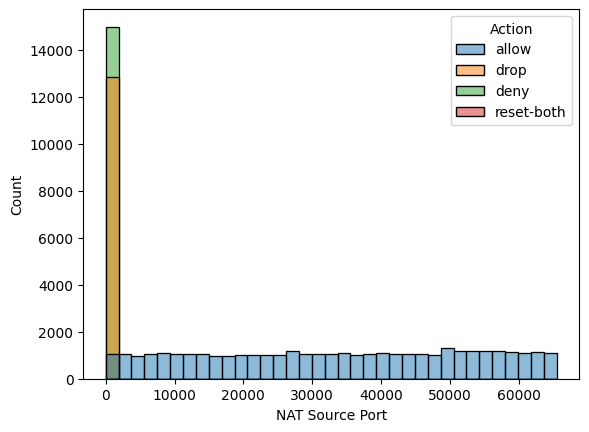

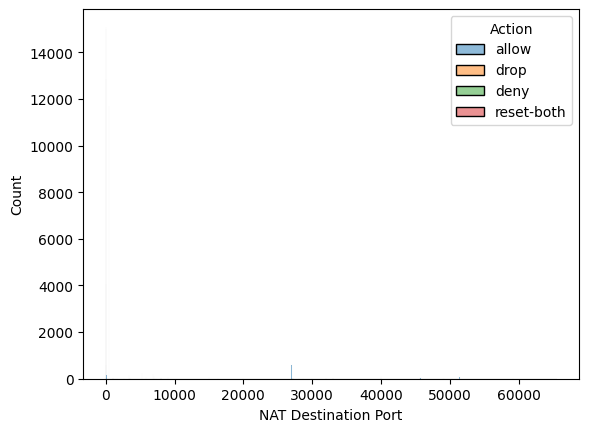

In [ ]:
for i in ["Source Port","Destination Port","NAT Source Port","NAT Destination Port"]:
    sns.histplot(x=i,data=dt, hue="Action")
    plt.show()

In [3]:
# We know the ports are not continuous. Thefore changing them to Obj
dt["Source Port"]=dt["Source Port"].astype(object)
dt["Destination Port"]=dt["Destination Port"].astype(object)
dt["NAT Source Port"]=dt["NAT Source Port"].astype(object)
dt["NAT Destination Port"]=dt["NAT Destination Port"].astype(object)

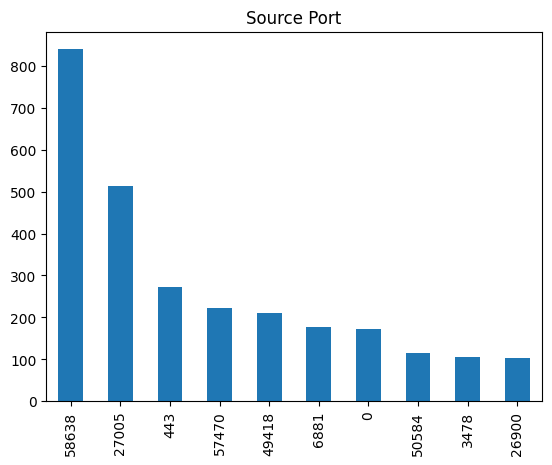

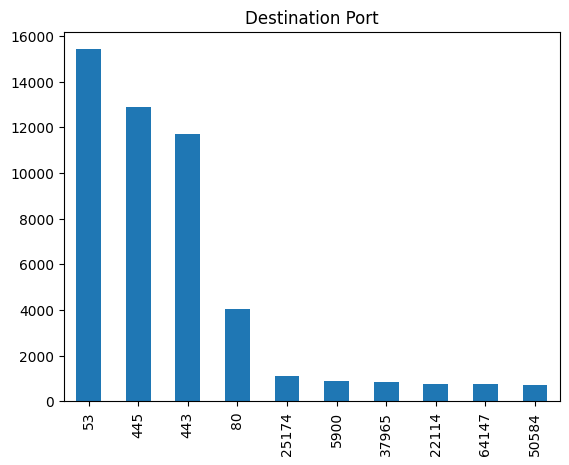

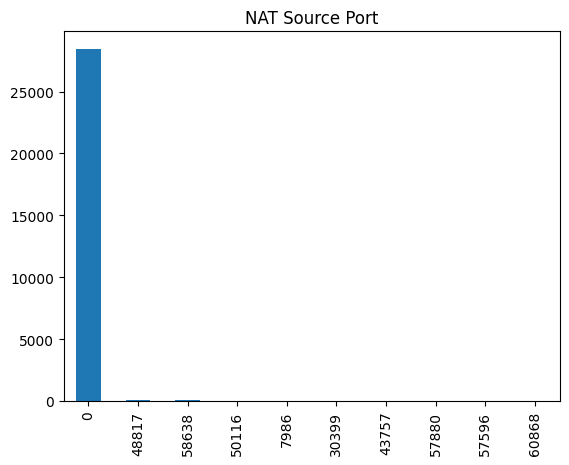

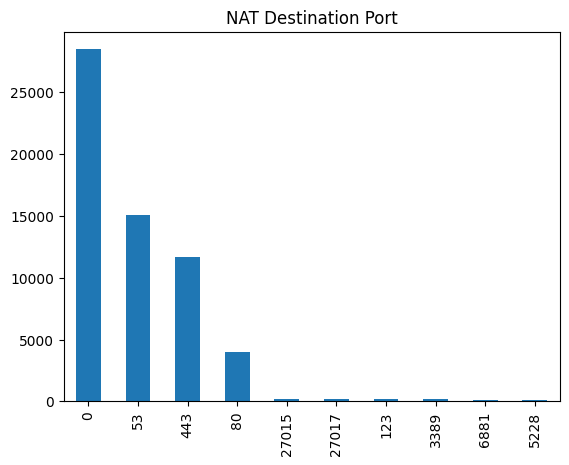

In [ ]:
# top 10 levels for each feature
for i in ['Source Port', 'Destination Port', 'NAT Source Port', 'NAT Destination Port']:
    dt[i].value_counts()[0:10].plot(kind='bar')
    plt.title(i)
    plt.show()

In [ ]:
dt[dt.duplicated()].head()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
268,21268,62609,0,0,deny,146,146,0,1,0,1,0
351,48706,23393,0,0,deny,60,60,0,1,0,1,0
593,65003,57470,0,0,deny,78,78,0,1,0,1,0
632,443,49988,0,0,deny,82,82,0,1,0,1,0
661,10669,49756,0,0,deny,60,60,0,1,0,1,0


In [ ]:
duplicate_indices = dt[dt.duplicated(keep='first')].index
duplicate_pairs = dt.loc[duplicate_indices]
duplicate_pairs.sort_values(by="Source Port")

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
59532,0,0,0,0,deny,60,60,0,1,0,1,0
9679,0,0,0,0,deny,156,156,0,2,0,2,0
17437,0,0,0,0,deny,70,70,0,1,0,1,0
9680,0,0,0,0,deny,156,156,0,2,0,2,0
53633,0,0,0,0,deny,98,98,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
26952,65516,445,0,0,drop,70,70,0,1,0,1,0
49047,65518,5710,0,0,deny,62,62,0,1,0,1,0
47568,65518,5710,0,0,deny,62,62,0,1,0,1,0
43621,65526,28793,0,0,deny,66,66,0,1,0,1,0


In [4]:
dt=dt.drop_duplicates()

# Most numeric variables center at 0 and just have outliers

Bytes


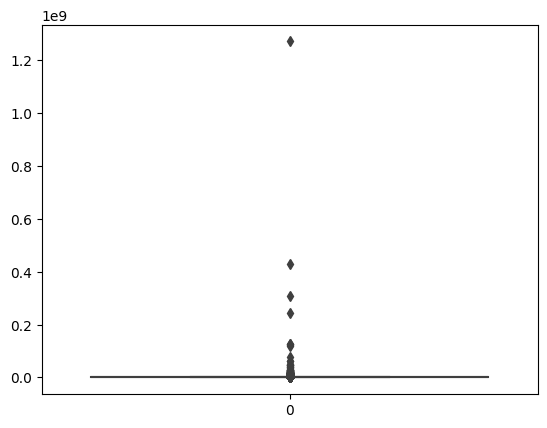

Bytes Sent


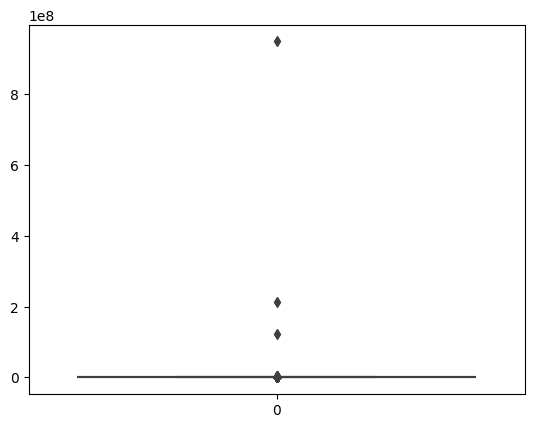

Bytes Received


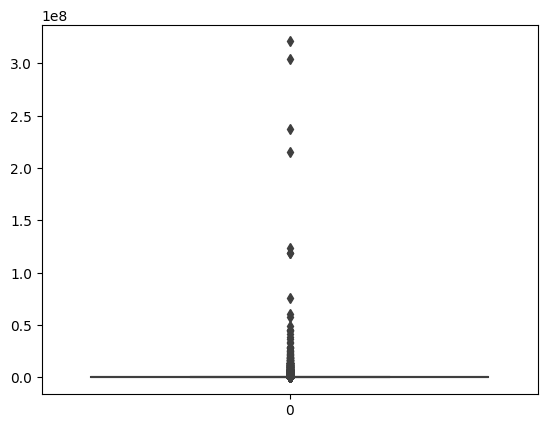

Packets


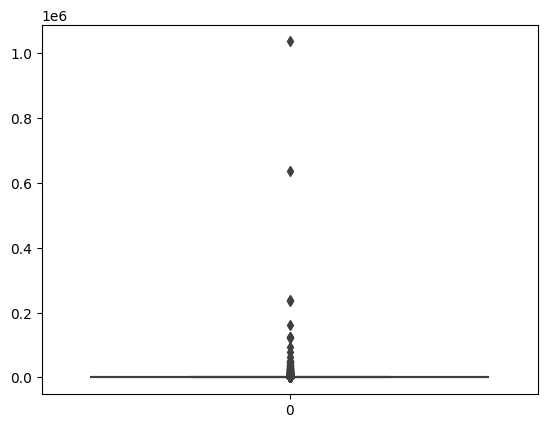

Elapsed Time (sec)


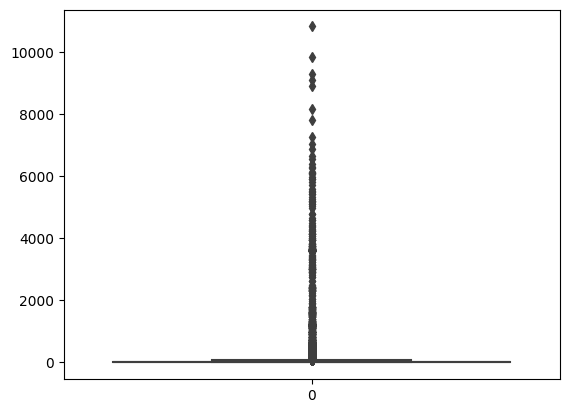

pkts_sent


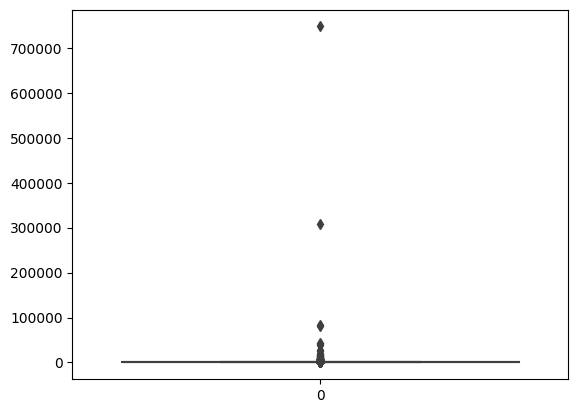

pkts_received


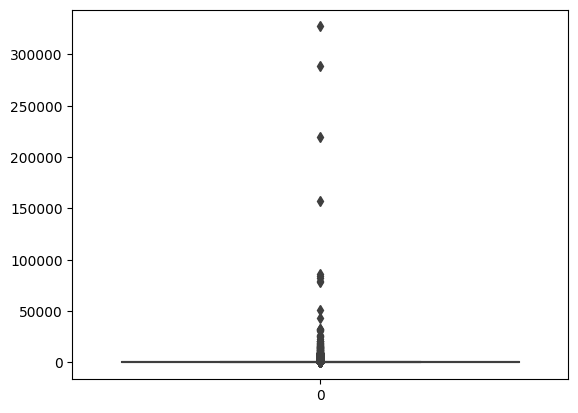

In [ ]:
for i in ['Bytes', 'Bytes Sent',
       'Bytes Received', 'Packets', 'Elapsed Time (sec)', 'pkts_sent',
       'pkts_received']:
    print(i)
    sns.boxplot(dt[i])
    plt.show()

In [5]:
import warnings
warnings.simplefilter('ignore', category=FutureWarning)
dt["SourceDestinationPort_Match"] = (dt["Source Port"] == dt["Destination Port"]).astype(int)


In [ ]:
# sns.pairplot(dt, diag_kind='kde')

# Not sure how to bucket the Ports so will not bucket them
+ No missing variable
+ Duplicates have been removed
+ Ready for model

In [ ]:
# Verify dtypes are correct one las time
dt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57170 entries, 0 to 65530
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Source Port                  57170 non-null  object
 1   Destination Port             57170 non-null  object
 2   NAT Source Port              57170 non-null  object
 3   NAT Destination Port         57170 non-null  object
 4   Action                       57170 non-null  object
 5   Bytes                        57170 non-null  int64 
 6   Bytes Sent                   57170 non-null  int64 
 7   Bytes Received               57170 non-null  int64 
 8   Packets                      57170 non-null  int64 
 9   Elapsed Time (sec)           57170 non-null  int64 
 10  pkts_sent                    57170 non-null  int64 
 11  pkts_received                57170 non-null  int64 
 12  SourceDestinationPort_Match  57170 non-null  int64 
dtypes: int64(8), object(5)
memory u

In [6]:
# One hot encode
categorical_columns = ['Source Port', 'Destination Port', 'NAT Source Port',
       'NAT Destination Port']
dt = pd.get_dummies(dt, columns=categorical_columns)

In [12]:
# Verify
dt.head()

,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received,SourceDestinationPort_Match,Source Port_0,...,NAT Destination Port_64932,NAT Destination Port_65054,NAT Destination Port_65100,NAT Destination Port_65128,NAT Destination Port_65253,NAT Destination Port_65264,NAT Destination Port_65387,NAT Destination Port_65427,NAT Destination Port_65534,NAT Destination Port_65535
0,allow,177,94,83,2,30,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,allow,4768,1600,3168,19,17,10,9,0,0,...,0,0,0,0,0,0,0,0,0,0
2,allow,238,118,120,2,1199,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,allow,3327,1438,1889,15,17,8,7,0,0,...,0,0,0,0,0,0,0,0,0,0
4,allow,25358,6778,18580,31,16,13,18,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
dt.shape

(57170, 57691)

In [7]:
y=dt['Action']
x=dt.drop('Action',axis=1)

In [8]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=1)

#scale the train the test data
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


In [11]:
x

,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received,SourceDestinationPort_Match,Source Port_0,Source Port_5,...,NAT Destination Port_64932,NAT Destination Port_65054,NAT Destination Port_65100,NAT Destination Port_65128,NAT Destination Port_65253,NAT Destination Port_65264,NAT Destination Port_65387,NAT Destination Port_65427,NAT Destination Port_65534,NAT Destination Port_65535
0,177,94,83,2,30,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4768,1600,3168,19,17,10,9,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,238,118,120,2,1199,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3327,1438,1889,15,17,8,7,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,25358,6778,18580,31,16,13,18,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65526,70,70,0,2,8,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
65527,314,192,122,6,15,4,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
65528,4680740,67312,4613428,4675,77,985,3690,0,0,0,...,0,0,0,0,0,0,0,0,0,0
65529,70,70,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### SGD Model 1 with hinge

In [17]:
from sklearn.linear_model import SGDClassifier
sgdc_model = SGDClassifier(loss = 'hinge')

In [14]:
sgdc_model.fit(X_train, y_train)

SGDClassifier()

In [15]:
preds = sgdc_model.predict(X_test)

In [22]:
from sklearn.metrics import classification_report

In [18]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

       allow       1.00      1.00      1.00      7511
        deny       0.99      0.99      0.99      1626
        drop       1.00      1.00      1.00      2289
  reset-both       0.33      0.12      0.18         8

    accuracy                           1.00     11434
   macro avg       0.83      0.78      0.79     11434
weighted avg       1.00      1.00      1.00     11434



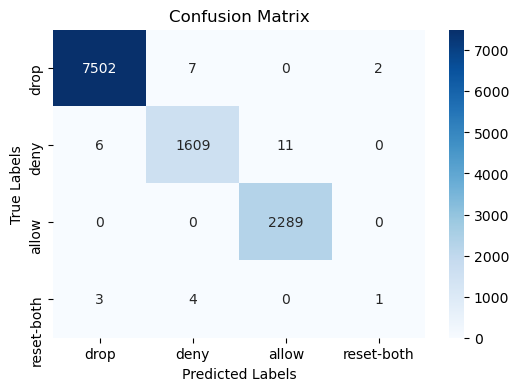

In [51]:
# Confusion Matrix
class_names = list(set(dt['Action']))
cm=confusion_matrix(y_test, preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#### Tuning the model with Randomized Search

In [9]:
from sklearn.model_selection import KFold, cross_val_score,LeaveOneOut
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_validate

In [18]:
sgd_classifier = SGDClassifier(random_state=42, n_jobs=-1,class_weight='balanced', early_stopping=True)

In [19]:
param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'loss': ['hinge']
}

In [24]:
sgd_random_search = RandomizedSearchCV(sgd_classifier, param_grid, cv=5, n_jobs=-1)

C:\Software\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


MemoryError: Unable to allocate 15.7 GiB for an array with shape (36588, 57690) and data type float64

In [ ]:
best_sgd_classifier = sgd_random_search.best_estimator_
best_sgd_classifier.fit(X_train, y_train)

# Evaluate the model on the test set
test_accuracy = best_sgd_classifier.score(X_test, y_test)

#### SGD Cross Validation

In [11]:
from sklearn.linear_model import SGDClassifier
sgd_classifier = SGDClassifier(random_state=42, n_jobs=-1,class_weight='balanced', early_stopping=True)

In [12]:
kfold = KFold(n_splits=10, shuffle=True)

In [37]:
# X = np.concatenate((X_train, X_test), axis=0)

In [13]:
cross_validate(sgd_classifier, np.concatenate((X_train, X_test), axis=0), cv= kfold)

MemoryError: Unable to allocate 24.6 GiB for an array with shape (57170, 57690) and data type float64

#### SGD Model 2 with log_loss

In [52]:
sgdc_loss_model = SGDClassifier(loss = 'log_loss')

In [53]:
sgdc_loss_model.fit(X_train, y_train)

SGDClassifier(loss='log_loss')

In [54]:
sgdc_loss_preds = sgdc_loss_model.predict(X_test)

In [55]:
print(classification_report(y_test, sgdc_loss_preds))

C:\Software\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       allow       1.00      1.00      1.00      7511
        deny       0.98      0.99      0.99      1626
        drop       1.00      1.00      1.00      2289
  reset-both       0.00      0.00      0.00         8

    accuracy                           1.00     11434
   macro avg       0.74      0.75      0.75     11434
weighted avg       1.00      1.00      1.00     11434



C:\Software\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Software\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


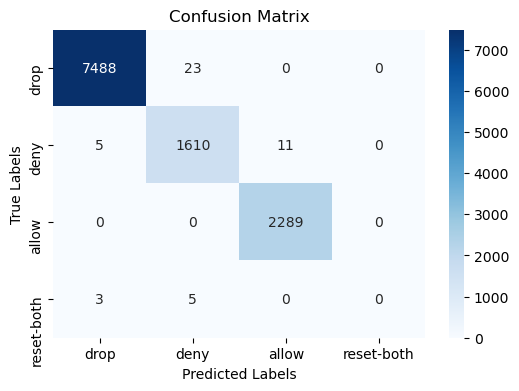

In [56]:
# Confusion Matrix
class_names = list(set(dt['Action']))
cm=confusion_matrix(y_test, sgdc_loss_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### SVC

In [19]:
# from sklearn.svm import SVC

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, stratify=y, random_state=1)

In [20]:
# svc_model = SVC(kernel = 'rbf', class_weight = 'balanced')

In [34]:
# svc_model.fit(X_train[:500], y_train[:500])

In [15]:
from sklearn.svm import LinearSVC

#### SVC Model 1

In [39]:
svc_lin_model = LinearSVC(dual = True, class_weight = 'balanced')

In [40]:
svc_lin_model.fit(X_train, y_train)

LinearSVC(class_weight='balanced')

In [41]:
svc_lin_pred = svc_lin_model.predict(X_test)

In [42]:
print(classification_report(y_test, svc_lin_pred))

              precision    recall  f1-score   support

       allow       1.00      1.00      1.00      7511
        deny       1.00      0.99      0.99      1626
        drop       1.00      1.00      1.00      2289
  reset-both       0.62      0.62      0.62         8

    accuracy                           1.00     11434
   macro avg       0.90      0.90      0.90     11434
weighted avg       1.00      1.00      1.00     11434



In [23]:
from sklearn.metrics import make_scorer, accuracy_score, precision_score,confusion_matrix,f1_score,recall_score

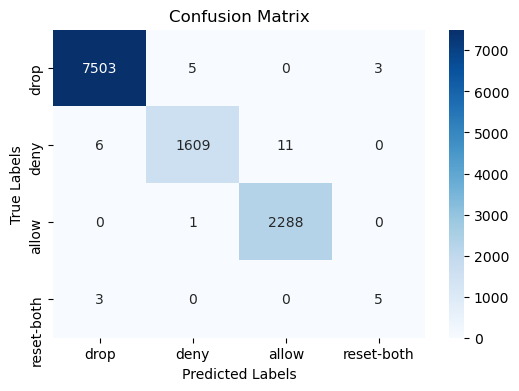

In [50]:
# Confusion Matrix
class_names = list(set(dt['Action']))
cm=confusion_matrix(y_test, svc_lin_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#### SVC Model 2 - Primal

In [57]:
primal = LinearSVC(dual = False, class_weight = 'balanced')

In [58]:
primal.fit(X_train, y_train)

LinearSVC(dual=False)

In [60]:
primal_pred = primal.predict(X_test)

In [61]:
print(classification_report(y_test, primal_pred))

              precision    recall  f1-score   support

       allow       1.00      1.00      1.00      7511
        deny       1.00      0.99      0.99      1626
        drop       1.00      1.00      1.00      2289
  reset-both       0.71      0.62      0.67         8

    accuracy                           1.00     11434
   macro avg       0.93      0.90      0.91     11434
weighted avg       1.00      1.00      1.00     11434



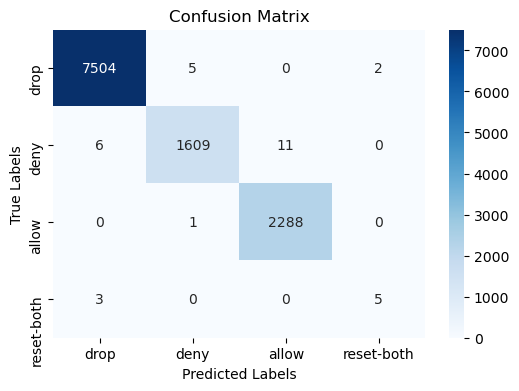

In [62]:
# Confusion Matrix
class_names = list(set(dt['Action']))
cm=confusion_matrix(y_test, primal_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [38]:
dt.memory_usage(deep=True).sum()/8/1000/1000

413.13657912499997

In [41]:
primal = LinearSVC(dual = False, class_weight = 'balanced')

In [42]:
param_grid = {
    'C': [0.0001, 0.001, 0.01, 0.1],
    'loss': ['hinge']
}
svc_random_search = RandomizedSearchCV(primal, param_grid, cv=5, n_jobs=-1)

In [43]:
svc_random_search.fit(X_train, y_train)

C:\Software\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


MemoryError: Unable to allocate 15.7 GiB for an array with shape (36588, 57690) and data type float64

In [ ]:
best_svc_params = svc_random_search.best_params_
best_svc_score = svc_random_search.best_score_

In [ ]:
best_linear_svc = svc_random_search.best_estimator_
best_linear_svc.fit(X_train, y_train)

##### Testing different C since random search didn't work due to memory size.

In [16]:
primal = LinearSVC(dual = False, class_weight = 'balanced', C=0.0001)

In [17]:
primal.fit(X_train, y_train)

LinearSVC(C=0.0001, class_weight='balanced', dual=False)

In [18]:
primal_pred = primal.predict(X_test)

In [21]:
print(classification_report(y_test, primal_pred))

C:\Software\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Software\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       allow       1.00      0.99      0.99      7511
        deny       0.95      0.99      0.97      1626
        drop       1.00      1.00      1.00      2289
  reset-both       0.00      0.00      0.00         8

    accuracy                           0.99     11434
   macro avg       0.74      0.75      0.74     11434
weighted avg       0.99      0.99      0.99     11434



C:\Software\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


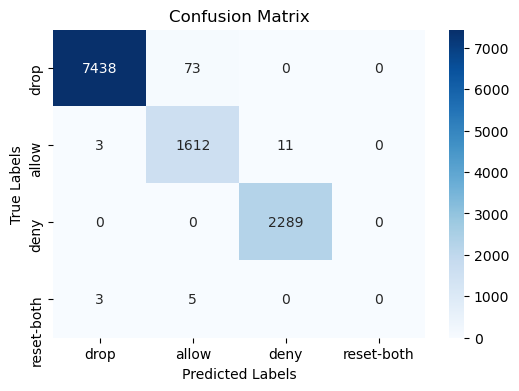

In [24]:
# Confusion Matrix
class_names = list(set(dt['Action']))
cm=confusion_matrix(y_test, primal_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [25]:
primal = LinearSVC(dual = False, class_weight = 'balanced', C=10)

In [26]:
primal.fit(X_train, y_train)

C:\Software\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=10, class_weight='balanced', dual=False)

In [27]:
primal_pred = primal.predict(X_test)

In [28]:
print(classification_report(y_test, primal_pred))

              precision    recall  f1-score   support

       allow       1.00      1.00      1.00      7511
        deny       0.99      0.99      0.99      1626
        drop       1.00      1.00      1.00      2289
  reset-both       0.71      0.62      0.67         8

    accuracy                           1.00     11434
   macro avg       0.93      0.90      0.91     11434
weighted avg       1.00      1.00      1.00     11434



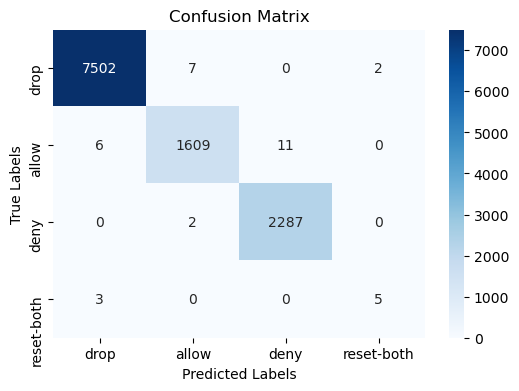

In [29]:
# Confusion Matrix
class_names = list(set(dt['Action']))
cm=confusion_matrix(y_test, primal_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [30]:
primal = LinearSVC(dual = False, class_weight = 'balanced', C=0.01)

In [31]:
primal.fit(X_train, y_train)

LinearSVC(C=0.01, class_weight='balanced', dual=False)

In [32]:
primal_pred = primal.predict(X_test)

In [33]:
print(classification_report(y_test, primal_pred))

              precision    recall  f1-score   support

       allow       1.00      1.00      1.00      7511
        deny       0.98      0.99      0.99      1626
        drop       1.00      1.00      1.00      2289
  reset-both       0.50      0.25      0.33         8

    accuracy                           1.00     11434
   macro avg       0.87      0.81      0.83     11434
weighted avg       1.00      1.00      1.00     11434



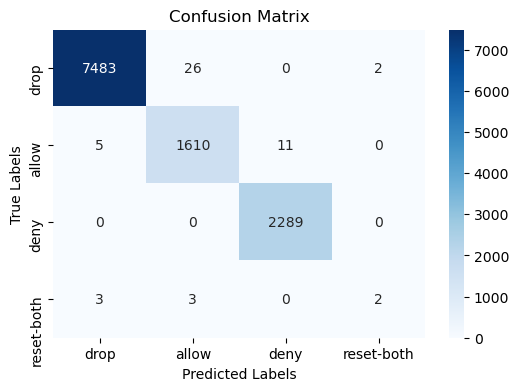

In [34]:
# Confusion Matrix
class_names = list(set(dt['Action']))
cm=confusion_matrix(y_test, primal_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()